In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew

import sys
sys.path.insert(0, '..')
from mlconfound.stats import _binom_ci
from mlconfound.simulate import sinh_arcsinh


In [2]:
alpha=0.05

In [3]:
df=pd.read_csv("../data_out/ccc_partial_normal_cat_c=False_cat_yyhat=False_delta_yc=1.0_delta_yhat=1.0_epsilon_yc=0.0_epsilon_yhat=0.0_mode='partial'_n_jobs=-1_nonlin_trf='identity'_out_file=None_out_prefix='ccc_partial_normal'_random_seed=4242.csv").iloc[:, 1:]
df['y_ratio'] = df.yc_in_yhat / (df.c_to_y_ratio_in_yhat+1)
df['c_ratio'] = df.yc_in_yhat * df.c_to_y_ratio_in_yhat / (df.c_to_y_ratio_in_yhat+1)
df['noise_ratio'] = 1 - (df.y_ratio + df.c_ratio)

df

,p,r2_y_c,r2_yhat_c,r2_y_yhat,n,c_to_y_ratio_in_yhat,yc_in_yhat,y_in_c,num_perms,random_seed,p_pc_pearson,p_pc_spearman,y_ratio,c_ratio,noise_ratio
0,0.312,0.005740,0.020067,0.007749,50,0.0,0.0,0.0,1000,1019282514,3.057750e-01,1.935406e-01,0.00,0.00,1.0
1,0.165,0.011478,0.041766,0.023440,50,0.0,0.0,0.0,1000,1679872250,1.206168e-01,2.395620e-01,0.00,0.00,1.0
2,0.702,0.029397,0.002973,0.001010,50,0.0,0.0,0.0,1000,1837932928,6.776117e-01,8.382253e-01,0.00,0.00,1.0
3,0.549,0.050442,0.008164,0.009753,50,0.0,0.0,0.0,1000,1442006727,6.311981e-01,3.930729e-01,0.00,0.00,1.0
4,0.912,0.017833,0.000171,0.000563,50,0.0,0.0,0.0,1000,221822463,9.110192e-01,3.501611e-01,0.00,0.00,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,0.000,0.938651,0.966991,0.973728,1000,1.0,0.9,0.8,1000,301235933,6.449245e-137,2.864159e-136,0.45,0.45,0.1
39996,0.000,0.935008,0.966648,0.970150,1000,1.0,0.9,0.8,1000,1011369396,4.689367e-147,7.400409e-144,0.45,0.45,0.1
39997,0.000,0.942195,0.969044,0.971995,1000,1.0,0.9,0.8,1000,1369868937,2.284653e-137,3.059143e-136,0.45,0.45,0.1
39998,0.000,0.937925,0.965199,0.972468,1000,1.0,0.9,0.8,1000,1775743152,1.847883e-127,5.050407e-129,0.45,0.45,0.1


In [4]:
def positive_rate(data, alpha=alpha):
    return (data < alpha).sum() / len(data)

In [5]:
df_yc_in_yhat = df[df.yc_in_yhat == 0]             # X contains information about neither y nor c: implies H0
df_c_to_y_ratio = df[df.c_to_y_ratio_in_yhat == 0]   # X contains information about c only trough y: implies H0

df_H1 = df[df.y_ratio != 0] 

df_H0 = pd.concat((df_yc_in_yhat, df_c_to_y_ratio)).drop_duplicates()
df_H0

,p,r2_y_c,r2_yhat_c,r2_y_yhat,n,c_to_y_ratio_in_yhat,yc_in_yhat,y_in_c,num_perms,random_seed,p_pc_pearson,p_pc_spearman,y_ratio,c_ratio,noise_ratio
0,0.312,0.005740,0.020067,0.007749,50,0.0,0.0,0.0,1000,1019282514,0.305775,0.193541,0.0,0.0,1.0
1,0.165,0.011478,0.041766,0.023440,50,0.0,0.0,0.0,1000,1679872250,0.120617,0.239562,0.0,0.0,1.0
2,0.702,0.029397,0.002973,0.001010,50,0.0,0.0,0.0,1000,1837932928,0.677612,0.838225,0.0,0.0,1.0
3,0.549,0.050442,0.008164,0.009753,50,0.0,0.0,0.0,1000,1442006727,0.631198,0.393073,0.0,0.0,1.0
4,0.912,0.017833,0.000171,0.000563,50,0.0,0.0,0.0,1000,221822463,0.911019,0.350161,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38395,0.385,0.937318,0.926656,0.987081,1000,0.0,0.9,0.8,1000,1040193158,0.404058,0.039176,0.9,0.0,0.1
38396,0.366,0.943977,0.933061,0.987187,1000,0.0,0.9,0.8,1000,364082909,0.471879,0.982392,0.9,0.0,0.1
38397,0.414,0.940479,0.929948,0.987345,1000,0.0,0.9,0.8,1000,1449959609,0.413118,0.493479,0.9,0.0,0.1
38398,0.140,0.937615,0.928822,0.986590,1000,0.0,0.9,0.8,1000,1597178978,0.031963,0.005551,0.9,0.0,0.1


In [6]:
print("False positive rate given H0:", positive_rate(df_H0.p))
print("Confidence intervals:", np.round(_binom_ci(len(df_H0.p)*0.05, len(df_H0.p)), 3))

False positive rate given H0: 0.03875
Confidence intervals: [0.047 0.053]


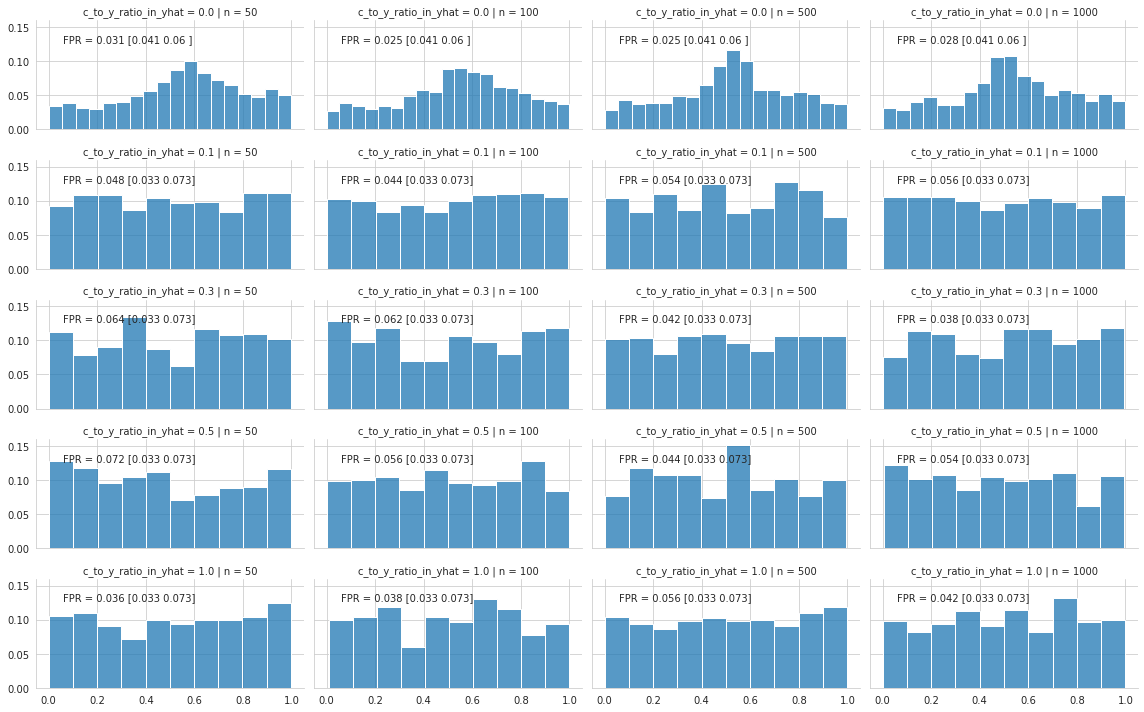

In [7]:
def annotate(data, **kws):
    FPR = positive_rate(data.p)
    ax = plt.gca()
    ax.text(0.1, .8, f"FPR = {np.round(FPR, 3)} {np.round(_binom_ci(len(data.p)*0.05, len(data.p)), 3)}", transform=ax.transAxes)

g=sns.FacetGrid(df_H0, col='n', row='c_to_y_ratio_in_yhat', height=2, aspect=2)
g.map(sns.histplot, "p", stat='probability')
g.map_dataframe(annotate)


In [8]:
df_H1 = df.loc[(df.c_to_y_ratio_in_yhat > 0) & (df.yc_in_yhat >0)]
df_H1

,p,r2_y_c,r2_yhat_c,r2_y_yhat,n,c_to_y_ratio_in_yhat,yc_in_yhat,y_in_c,num_perms,random_seed,p_pc_pearson,p_pc_spearman,y_ratio,c_ratio,noise_ratio
2400,0.985,0.000430,0.000005,0.303202,50,0.1,0.3,0.0,1000,323672003,9.105299e-01,4.666100e-01,0.272727,0.027273,0.7
2401,0.695,0.007131,0.002594,0.156621,50,0.1,0.3,0.0,1000,1931310255,8.961704e-01,5.859459e-01,0.272727,0.027273,0.7
2402,0.571,0.046569,0.006961,0.044823,50,0.1,0.3,0.0,1000,983343362,7.872947e-01,6.615184e-01,0.272727,0.027273,0.7
2403,0.317,0.053483,0.025759,0.097470,50,0.1,0.3,0.0,1000,18978686,8.096749e-02,1.113488e-01,0.272727,0.027273,0.7
2404,0.548,0.031978,0.010065,0.127058,50,0.1,0.3,0.0,1000,1136612079,7.860106e-01,9.246690e-01,0.272727,0.027273,0.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,0.000,0.938651,0.966991,0.973728,1000,1.0,0.9,0.8,1000,301235933,6.449245e-137,2.864159e-136,0.450000,0.450000,0.1
39996,0.000,0.935008,0.966648,0.970150,1000,1.0,0.9,0.8,1000,1011369396,4.689367e-147,7.400409e-144,0.450000,0.450000,0.1
39997,0.000,0.942195,0.969044,0.971995,1000,1.0,0.9,0.8,1000,1369868937,2.284653e-137,3.059143e-136,0.450000,0.450000,0.1
39998,0.000,0.937925,0.965199,0.972468,1000,1.0,0.9,0.8,1000,1775743152,1.847883e-127,5.050407e-129,0.450000,0.450000,0.1


0.01 0.01 0.01
0.01 0.01 0.01
0.01 0.01 0.01
0.01 0.01 0.01
0.01 0.01 0.01
0.16 0.07 0.07
0.15 0.07 0.07
0.12 0.07 0.07
0.11 0.08 0.08
0.09 0.09 0.09
0.69 0.28 0.28
0.67 0.29 0.29
0.61 0.33 0.33
0.56 0.36 0.36
0.46 0.43 0.43
0.99 0.4 0.4
0.98 0.43 0.43
0.95 0.49 0.49
0.9 0.56 0.56
0.78 0.71 0.71


/home/tspisak/src/mlconfound/venv/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)


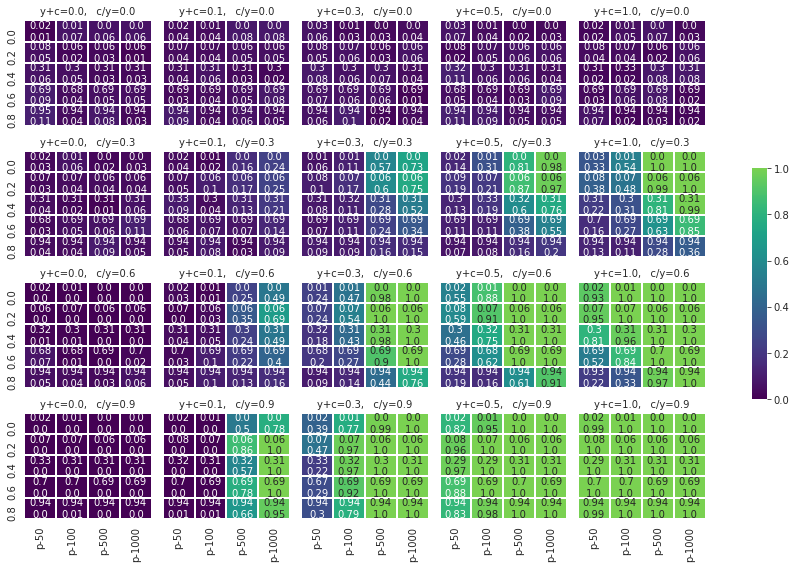

In [14]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    '''
    https://stackoverflow.com/a/18926541
    '''
    if isinstance(cmap, str):
        cmap = plt.get_cmap(cmap)
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def positive_rate_heatmap(data, col_a, col_b, value, **kws):
    
    r2_y_yhat = data.pivot_table(index=col_b, values=['r2_y_yhat'], columns=col_a, aggfunc=np.mean)
    r2_y_c = data.pivot_table(index=col_b, values=['r2_y_c'], columns=col_a, aggfunc=np.mean)
    r2_yhat_c = data.pivot_table(index=col_b, values=['r2_yhat_c'], columns=col_a, aggfunc=np.mean)
    
    pr = data.pivot_table(index=col_b, values=[value], columns=col_a, aggfunc=positive_rate)
    
    annot = np.round(r2_y_c, 2).astype(str).values + '\n' + np.round(pr, 2).astype(str).values
    
    print(np.round(np.mean(r2_y_yhat.values), 2),
          np.round(np.mean(r2_yhat_c.values), 2),
          np.round(np.mean(r2_yhat_c.values), 2))
    
    sns.heatmap(data.pivot_table(index=col_b, values=[value], columns=col_a, aggfunc=positive_rate),
                linewidths=0.2,
                vmin=0, vmax=1,
                cmap=truncate_colormap(sns.color_palette("viridis", as_cmap=True), 0, 0.8),
                annot=annot, #True,
                fmt='',
                #annot=True,
                **kws)

g=sns.FacetGrid(df, col='c_to_y_ratio_in_yhat', row='yc_in_yhat', height=2, aspect=1)
cbar_ax = g.fig.add_axes([1.05, .3, .02, .4])  # <-- Create a colorbar axes

g.map_dataframe(positive_rate_heatmap, col_a='n', col_b='y_in_c', value='p', cbar_ax=cbar_ax,)
g.set_titles("y+c={col_name},   c/y={row_name}")

#plt.savefig('../data_out/fig/sim_ccc_normal_all_heatmap.pdf')

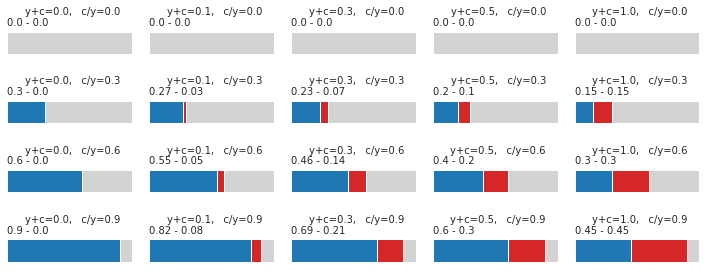

In [12]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    '''
    https://stackoverflow.com/a/18926541
    '''
    if isinstance(cmap, str):
        cmap = plt.get_cmap(cmap)
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def positive_rate_heatmap(data, col_a, col_b, value, **kws):
    
    df_bar = pd.DataFrame({
        'y_ratio': [data['y_ratio'].mean()],
        'c_ratio': [data['c_ratio'].mean()],
        'noise_ratio': [data['noise_ratio'].mean()]
    })
    df_bar.plot(kind='barh', stacked=True, color=['tab:blue', 'tab:red', 'lightgray'],
                      legend=False, ax=plt.gca())
    plt.grid(False)
    plt.axis('off')
    plt.text(0,0.4, str(np.round(df_bar.y_ratio[0], 2)) + ' - ' + str(np.round(df_bar.c_ratio[0], 2)))

g=sns.FacetGrid(df, col='c_to_y_ratio_in_yhat', row='yc_in_yhat', height=1, aspect=2)

g.map_dataframe(positive_rate_heatmap, col_a='n', col_b='y_c_ratio', value='p')
g.set_titles("y+c={col_name},   c/y={row_name}")

plt.savefig('../data_out/fig/sim_weights_heatmap.pdf')

# non-normality

In [15]:
df_d100_e1=pd.read_csv("../data_out/ccc_partial_non-normal-all_cat_c=False_cat_yyhat=False_delta_yc=1.0_delta_yhat=1.0_epsilon_yc=1.0_epsilon_yhat=1.0_mode='partial'_n_jobs=-1_nonlin_trf='identity'_out_file=None_out_prefix='ccc_partial_non-normal-all'_random_seed=4242.csv").iloc[:, 1:]
df_d105_e3=pd.read_csv("../data_out/ccc_partial_non-normal-all2_cat_c=False_cat_yyhat=False_delta_yc=1.05_delta_yhat=1.05_epsilon_yc=3.0_epsilon_yhat=3.0_mode='partial'_n_jobs=-1_nonlin_trf='identity'_out_file=None_out_prefix='ccc_partial_non-normal-all2'_random_seed=4242.csv").iloc[:, 1:]
df_d150_e5=pd.read_csv("../data_out/ccc_partial_non-normal-all3_cat_c=False_cat_yyhat=False_delta_yc=1.5_delta_yhat=1.5_epsilon_yc=5.0_epsilon_yhat=5.0_mode='partial'_n_jobs=-1_nonlin_trf='identity'_out_file=None_out_prefix='ccc_partial_non-normal-all3'_random_seed=4242.csv").iloc[:, 1:]
df_d500_e10=pd.read_csv("../data_out/ccc_partial_non-normal-a").iloc[:, 1:]
df_d500_en10=pd.read_csv("../data_out/ccc_partial_non-normal-all5_cat_c=False_cat_yyhat=False_delta_yc=5.0_delta_yhat=5.0_epsilon_yc=-10.0_epsilon_yhat=-10.0_mode='partial'_n_jobs=-1_out_file=None_out_prefix='ccc_partial_non-normal-all5'_random_seed=4242.csv").iloc[:, 1:]



df_yc_in_yhat = df_d100_e1[df.yc_in_yhat == 0]             # X contains information about neither y nor c: implies H0
df_c_to_y_ratio = df_d100_e1[df.c_to_y_ratio_in_yhat == 0]   # X contains information about c only trough y: implies H0
df_d100_e1_H0 = pd.concat((df_yc_in_yhat, df_c_to_y_ratio)).drop_duplicates()

df_yc_in_yhat = df_d105_e3[df.yc_in_yhat == 0]             # X contains information about neither y nor c: implies H0
df_c_to_y_ratio = df_d105_e3[df.c_to_y_ratio_in_yhat == 0]   # X contains information about c only trough y: implies H0
df_d105_e3_H0 = pd.concat((df_yc_in_yhat, df_c_to_y_ratio)).drop_duplicates()

df_yc_in_yhat = df_d150_e5[df.yc_in_yhat == 0]             # X contains information about neither y nor c: implies H0
df_c_to_y_ratio = df_d150_e5[df.c_to_y_ratio_in_yhat == 0]   # X contains information about c only trough y: implies H0
df_d150_e5_H0 = pd.concat((df_yc_in_yhat, df_c_to_y_ratio)).drop_duplicates()

df_yc_in_yhat = df_d500_e10[df.yc_in_yhat == 0]             # X contains information about neither y nor c: implies H0
df_c_to_y_ratio = df_d500_e10[df.c_to_y_ratio_in_yhat == 0]   # X contains information about c only trough y: implies H0
df_d500_e10_H0 = pd.concat((df_yc_in_yhat, df_c_to_y_ratio)).drop_duplicates()

df_yc_in_yhat = df_d500_en10[df.yc_in_yhat == 0]             # X contains information about neither y nor c: implies H0
df_c_to_y_ratio = df_d500_en10[df.c_to_y_ratio_in_yhat == 0]   # X contains information about c only trough y: implies H0
df_d500_en10_H0 = pd.concat((df_yc_in_yhat, df_c_to_y_ratio)).drop_duplicates()

#################################################################################

df_d100_e1['c_ratio'] = df_d100_e1.yc_in_yhat / (df_d100_e1.c_to_y_ratio_in_yhat+1)
df_d100_e1_H1 = df_d100_e1[df_d100_e1.c_ratio != 0] 

df_d105_e3['c_ratio'] = df_d105_e3.yc_in_yhat / (df_d105_e3.c_to_y_ratio_in_yhat+1)
df_d105_e3_H1 = df_d105_e3[df_d105_e3.c_ratio != 0] 

df_d150_e5['c_ratio'] = df_d150_e5.yc_in_yhat / (df_d100_e1.c_to_y_ratio_in_yhat+1)
df_d150_e5_H1 = df_d150_e5[df_d150_e5.c_ratio != 0] 

df_d500_e10['c_ratio'] = df_d500_e10.yc_in_yhat / (df_d500_e10.c_to_y_ratio_in_yhat+1)
df_d500_e10_H1 = df_d500_e10[df_d500_e10.c_ratio != 0] 



df_d500_e10_H1

FileNotFoundError: [Errno 2] No such file or directory: "../data_out/ccc_partial_non-normal-all_cat_c=False_cat_yyhat=False_delta_yc=1.0_delta_yhat=1.0_epsilon_yc=1.0_epsilon_yhat=1.0_mode='partial'_n_jobs=-1_out_file=None_out_prefix='ccc_partial_non-normal-all'_random_seed=4242.csv"

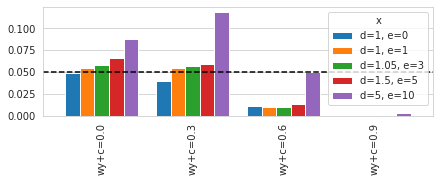

In [12]:
x=["d=1, e=0", "d=1, e=1", "d=1.05, e=3", "d=1.5, e=5", "d=5, e=10"]
fpr0=[
    positive_rate(df_H0[df_H0.yc_in_yhat==0].p),
    positive_rate(df_d100_e1_H0[df_d100_e1_H0.yc_in_yhat==0].p),
    positive_rate(df_d105_e3_H0[df_d105_e3_H0.yc_in_yhat==0].p),
    positive_rate(df_d150_e5_H0[df_d150_e5_H0.yc_in_yhat==0].p),
    positive_rate(df_d500_e10_H0[df_d500_e10_H0.yc_in_yhat==0].p)
    ]
##############################
fpr1=[
    positive_rate(df_H0[df_H0.yc_in_yhat==0.3].p),
    positive_rate(df_d100_e1_H0[df_d100_e1_H0.yc_in_yhat==0.3].p),
    positive_rate(df_d105_e3_H0[df_d105_e3_H0.yc_in_yhat==0.3].p),
    positive_rate(df_d150_e5_H0[df_d150_e5_H0.yc_in_yhat==0.3].p),
    positive_rate(df_d500_e10_H0[df_d500_e10_H0.yc_in_yhat==0.3].p)
    ]
##############################
fpr2=[
    positive_rate(df_H0[df_H0.yc_in_yhat==0.6].p),
    positive_rate(df_d100_e1_H0[df_d100_e1_H0.yc_in_yhat==0.6].p),
    positive_rate(df_d105_e3_H0[df_d105_e3_H0.yc_in_yhat==0.6].p),
    positive_rate(df_d150_e5_H0[df_d150_e5_H0.yc_in_yhat==0.6].p),
    positive_rate(df_d500_e10_H0[df_d500_e10_H0.yc_in_yhat==0.6].p)
    ]
##############################
fpr3=[
    positive_rate(df_H0[df_H0.yc_in_yhat==0.9].p),
    positive_rate(df_d100_e1_H0[df_d100_e1_H0.yc_in_yhat==0.9].p),
    positive_rate(df_d105_e3_H0[df_d105_e3_H0.yc_in_yhat==0.9].p),
    positive_rate(df_d150_e5_H0[df_d150_e5_H0.yc_in_yhat==0.9].p),
    positive_rate(df_d500_e10_H0[df_d500_e10_H0.yc_in_yhat==0.9].p)
    ]
df_bar=pd.DataFrame({
    'wy+c=0.0' : fpr0,
    'wy+c=0.3' : fpr1,
    'wy+c=0.6' : fpr2,
    'wy+c=0.9' : fpr3,
    'x' : x
})

ax=df_bar.set_index('x').transpose().plot(kind='bar', width=.8, figsize=(7,2))
ax.grid(axis='x')
plt.axhline(0.05, color='black', linestyle='--')
plt.savefig('../data_out/fig/sim_norm_violated.pdf')


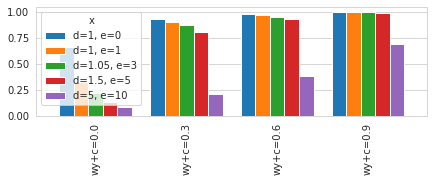

In [13]:
x=["d=1, e=0", "d=1, e=1", "d=1.05, e=3", "d=1.5, e=5", "d=5, e=10"]

n=1000

fpr0=[
    positive_rate(df_H1[(df_H1.c_to_y_ratio_in_yhat==0.1) & (df_H1.n == n)].p),
    positive_rate(df_d100_e1_H1[(df_d100_e1_H1.c_to_y_ratio_in_yhat==0.1) & (df_d100_e1_H1.n == n)].p),
    positive_rate(df_d105_e3_H1[(df_d105_e3_H1.c_to_y_ratio_in_yhat==0.1) & (df_d105_e3_H1.n == n)].p),
    positive_rate(df_d150_e5_H1[(df_d150_e5_H1.c_to_y_ratio_in_yhat==0.1) & (df_d150_e5_H1.n == n)].p),
    positive_rate(df_d500_e10_H1[(df_d500_e10_H1.c_to_y_ratio_in_yhat==0.1) & (df_d500_e10_H1.n == n)].p)
    ]
##############################
fpr1=[
    positive_rate(df_H1[(df_H1.c_to_y_ratio_in_yhat==0.3) & (df_H1.n == n)].p),
    positive_rate(df_d100_e1_H1[(df_d100_e1_H1.c_to_y_ratio_in_yhat==0.3) & (df_d100_e1_H1.n == n)].p),
    positive_rate(df_d105_e3_H1[(df_d105_e3_H1.c_to_y_ratio_in_yhat==0.3) & (df_d105_e3_H1.n == n)].p),
    positive_rate(df_d150_e5_H1[(df_d150_e5_H1.c_to_y_ratio_in_yhat==0.3) & (df_d150_e5_H1.n == n)].p),
    positive_rate(df_d500_e10_H1[(df_d500_e10_H1.c_to_y_ratio_in_yhat==0.3) & (df_d500_e10_H1.n == n)].p)
    ]
##############################
fpr2=[
    positive_rate(df_H1[(df_H1.c_to_y_ratio_in_yhat==0.5) & (df_H1.n == n)].p),
    positive_rate(df_d100_e1_H1[(df_d100_e1_H1.c_to_y_ratio_in_yhat==0.5) & (df_d100_e1_H1.n == n)].p),
    positive_rate(df_d105_e3_H1[(df_d105_e3_H1.c_to_y_ratio_in_yhat==0.5) & (df_d105_e3_H1.n == n)].p),
    positive_rate(df_d150_e5_H1[(df_d150_e5_H1.c_to_y_ratio_in_yhat==0.5) & (df_d150_e5_H1.n == n)].p),
    positive_rate(df_d500_e10_H1[(df_d500_e10_H1.c_to_y_ratio_in_yhat==0.5) & (df_d500_e10_H1.n == n)].p)
    ]
##############################
fpr3=[
    positive_rate(df_H1[(df_H1.c_to_y_ratio_in_yhat==1) & (df_H1.n == n)].p),
    positive_rate(df_d100_e1_H1[(df_d100_e1_H1.c_to_y_ratio_in_yhat==1) & (df_d100_e1_H1.n == n)].p),
    positive_rate(df_d105_e3_H1[(df_d105_e3_H1.c_to_y_ratio_in_yhat==1) & (df_d105_e3_H1.n == n)].p),
    positive_rate(df_d150_e5_H1[(df_d150_e5_H1.c_to_y_ratio_in_yhat==1) & (df_d150_e5_H1.n == n)].p),
    positive_rate(df_d500_e10_H1[(df_d500_e10_H1.c_to_y_ratio_in_yhat==1) & (df_d500_e10_H1.n == n)].p)
    ]
df_bar=pd.DataFrame({
    'wy+c=0.0' : fpr0,
    'wy+c=0.3' : fpr1,
    'wy+c=0.6' : fpr2,
    'wy+c=0.9' : fpr3,
    'x' : x
})

ax=df_bar.set_index('x').transpose().plot(kind='bar', width=.8, figsize=(7,2))
ax.grid(axis='x')
plt.savefig('../data_out/fig/sim_norm_violated_power_n1000.pdf')


In [14]:
df_H1[(df_H1.c_to_y_ratio_in_yhat==0.1) & (df_H1.n == n)].p

2700     0.091
2701     0.859
2702     0.933
2703     0.069
2704     0.037
         ...  
38795    0.000
38796    0.000
38797    0.000
38798    0.001
38799    0.001
Name: p, Length: 1500, dtype: float64

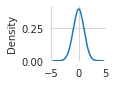

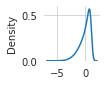

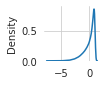

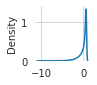

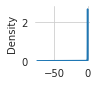

In [15]:
def std(x):
    return (x-np.mean(x)) / np.std(x)

x = np.random.normal(0,1,100000)

plt.figure(figsize=(1,1))
plt.box(on=None)
sns.kdeplot(std(sinh_arcsinh(x, delta=1, epsilon=0)))
plt.savefig('../data_out/fig/sim_dist1.pdf')
plt.show()
plt.figure(figsize=(1,1))
plt.box(on=None)
sns.kdeplot(std(sinh_arcsinh(x, delta=1, epsilon=1)))
plt.savefig('../data_out/fig/sim_dist2.pdf')
plt.show()
plt.figure(figsize=(1,1))
plt.box(on=None)
sns.kdeplot(std(sinh_arcsinh(x, delta=1.05, epsilon=3)))
plt.savefig('../data_out/fig/sim_dist3.pdf')
plt.show()
plt.figure(figsize=(1,1))
plt.box(on=None)
sns.kdeplot(std(sinh_arcsinh(x, delta=1.5, epsilon=5)))
plt.savefig('../data_out/fig/sim_dist4.pdf')
plt.show()
plt.figure(figsize=(1,1))
plt.box(on=None)
sns.kdeplot(std(sinh_arcsinh(x, delta=5, epsilon=10)))
plt.savefig('../data_out/fig/sim_dist5.pdf')


In [16]:
skews=[]
kurts=[]

for i in range(1000):
    y = np.random.normal(0,1,100)
    # Skewness, with Heavy Tails
    yhat_t = sinh_arcsinh(y, delta=5, epsilon=10)
    kurts.append(kurtosis(yhat_t))
    skews.append(skew(yhat_t))

np.round((np.mean(kurts), np.mean(skews)), 2)

array([42.58, -6.09])

In [17]:
print("Confidence intervals global:", np.round(_binom_ci(len(df_H0.p)*0.05, len(df_H0.p)), 3))
print("Confidence intervals per simulation case:", np.round(_binom_ci(100*0.05, 100), 3))
print("Expected number of out-of-confidence H0 simulations:", 5*5*8*0.05)
print("With the upper confidence limit:", _binom_ci(5*5*8*0.05, 5*5*8)[1]*5*5*8)

Confidence intervals global: [0.047 0.053]
Confidence intervals per simulation case: [0.016 0.113]
Expected number of out-of-confidence H0 simulations: 10.0
With the upper confidence limit: 18.005507540270273


In [11]:
df_full=pd.read_csv("../data_out/bbb_full_normal_cat_c=True_cat_yyhat=True_delta_yc=1.0_delta_yhat=1.0_epsilon_yc=0.0_epsilon_yhat=0.0_mode='full'_n_jobs=-1_out_file=None_out_prefix='bbb_full_normal'_random_seed=4242.csv").iloc[:, 1:]

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    '''
    https://stackoverflow.com/a/18926541
    '''
    if isinstance(cmap, str):
        cmap = plt.get_cmap(cmap)
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def positive_rate_heatmap(data, col_a, col_b, value, **kws):
    
    r2_y_yhat = data.pivot_table(index=col_b, values=['r2_y_yhat'], columns=col_a, aggfunc=np.mean)
    r2_y_c = data.pivot_table(index=col_b, values=['r2_y_c'], columns=col_a, aggfunc=np.mean)
    r2_yhat_c = data.pivot_table(index=col_b, values=['r2_yhat_c'], columns=col_a, aggfunc=np.mean)
    
    pr = data.pivot_table(index=col_b, values=[value], columns=col_a, aggfunc=positive_rate)
    
    annot = np.round(r2_y_c, 2).astype(str).values + '\n' + np.round(pr, 2).astype(str).values
    
    sns.heatmap(data.pivot_table(index=col_b, values=[value], columns=col_a, aggfunc=positive_rate),
                linewidths=0.2,
                vmin=0, vmax=1,
                cmap=truncate_colormap(sns.color_palette("viridis", as_cmap=True), 0, 0.8),
                annot=annot, #True,
                fmt='',
                #annot=True,
                **kws)

g=sns.FacetGrid(df_full, col='y_to_c_ratio_in_yhat', row='yc_in_yhat', height=2, aspect=1)
cbar_ax = g.fig.add_axes([1.05, .3, .02, .4])  # <-- Create a colorbar axes

g.map_dataframe(positive_rate_heatmap, col_a='n', col_b='y_c_ratio', value='p', cbar_ax=cbar_ax,)
g.set_titles("y+c={col_name},   y/c={row_name}")

#plt.savefig('../data_out/fig/sim_ccb_full_normal_all_heatmap.pdf')

FileNotFoundError: [Errno 2] No such file or directory: "../data_out/bbb_full_normal_cat_c=True_cat_yyhat=True_delta_yc=1.0_delta_yhat=1.0_epsilon_yc=0.0_epsilon_yhat=0.0_mode='full'_n_jobs=-1_out_file=None_out_prefix='bbb_full_normal'_random_seed=4242.csv"

/home/tspisak/src/mlconfound/venv/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)


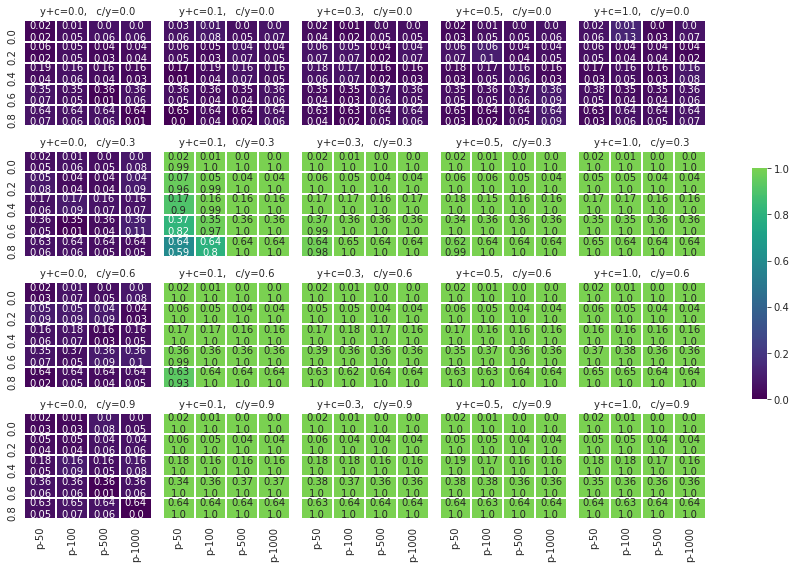

In [57]:
df_partial=pd.read_csv("../data_out/_spearman_test2_cat_c=False_cat_yyhat=False_delta_yc=2.0_delta_yhat=1.0_epsilon_yc=3.0_epsilon_yhat=0.0_mode='partial_spearman'_n_jobs=-1_out_file=None_out_prefix='_spearman_test2'_random_seed=4242.csv").iloc[:, 1:]
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    '''
    https://stackoverflow.com/a/18926541
    '''
    if isinstance(cmap, str):
        cmap = plt.get_cmap(cmap)
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def positive_rate_heatmap(data, col_a, col_b, value, **kws):
    
    r2_y_yhat = data.pivot_table(index=col_b, values=['r2_y_yhat'], columns=col_a, aggfunc=np.mean)
    r2_y_c = data.pivot_table(index=col_b, values=['r2_y_c'], columns=col_a, aggfunc=np.mean)
    r2_yhat_c = data.pivot_table(index=col_b, values=['r2_yhat_c'], columns=col_a, aggfunc=np.mean)
    
    pr = data.pivot_table(index=col_b, values=[value], columns=col_a, aggfunc=positive_rate)
    
    annot = np.round(r2_y_c, 2).astype(str).values + '\n' + np.round(pr, 2).astype(str).values
    
    sns.heatmap(data.pivot_table(index=col_b, values=[value], columns=col_a, aggfunc=positive_rate),
                linewidths=0.2,
                vmin=0, vmax=1,
                cmap=truncate_colormap(sns.color_palette("viridis", as_cmap=True), 0, 0.8),
                annot=annot, #True,
                fmt='',
                #annot=True,
                **kws)

g=sns.FacetGrid(df_partial, col='c_to_y_ratio_in_yhat', row='yc_in_yhat', height=2, aspect=1)
cbar_ax = g.fig.add_axes([1.05, .3, .02, .4])  # <-- Create a colorbar axes

g.map_dataframe(positive_rate_heatmap, col_a='n', col_b='cov_y_c', value='p', cbar_ax=cbar_ax,)
g.set_titles("y+c={col_name},   c/y={row_name}")

#plt.savefig('../data_out/fig/sim_ccb_partial_normal_all_heatmap.pdf')

/home/tspisak/src/mlconfound/venv/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)


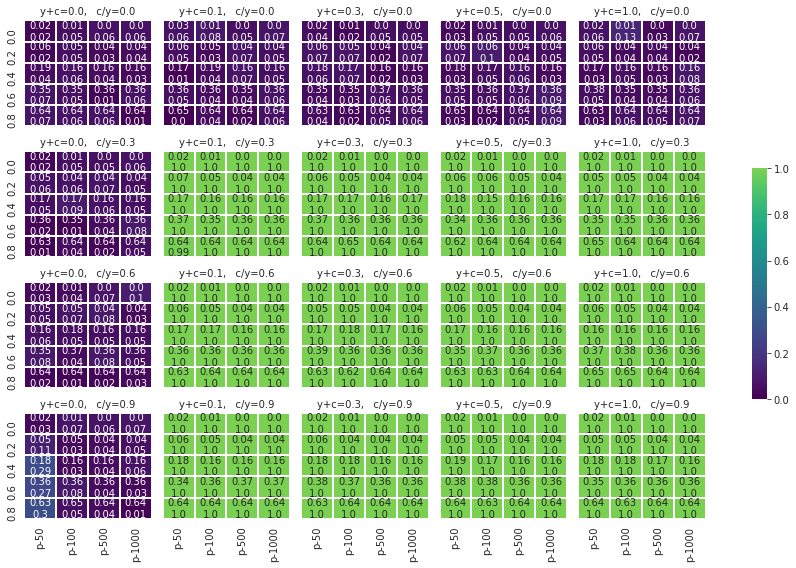

In [61]:
df_partial=pd.read_csv("../data_out/_spearman_test2_cat_c=False_cat_yyhat=False_delta_yc=3.0_delta_yhat=1.0_epsilon_yc=5.0_epsilon_yhat=0.0_mode='partial_spearman'_n_jobs=-1_out_file=None_out_prefix='_spearman_test2'_random_seed=4242.csv").iloc[:, 1:]
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    '''
    https://stackoverflow.com/a/18926541
    '''
    if isinstance(cmap, str):
        cmap = plt.get_cmap(cmap)
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def positive_rate_heatmap(data, col_a, col_b, value, **kws):

    r2_y_yhat = data.pivot_table(index=col_b, values=['r2_y_yhat'], columns=col_a, aggfunc=np.mean)
    r2_y_c = data.pivot_table(index=col_b, values=['r2_y_c'], columns=col_a, aggfunc=np.mean)
    r2_yhat_c = data.pivot_table(index=col_b, values=['r2_yhat_c'], columns=col_a, aggfunc=np.mean)

    pr = data.pivot_table(index=col_b, values=[value], columns=col_a, aggfunc=positive_rate)

    annot = np.round(r2_y_c, 2).astype(str).values + '\n' + np.round(pr, 2).astype(str).values

    sns.heatmap(data.pivot_table(index=col_b, values=[value], columns=col_a, aggfunc=positive_rate),
                linewidths=0.2,
                vmin=0, vmax=1,
                cmap=truncate_colormap(sns.color_palette("viridis", as_cmap=True), 0, 0.8),
                annot=annot, #True,
                fmt='',
                #annot=True,
                **kws)

g=sns.FacetGrid(df_partial, col='c_to_y_ratio_in_yhat', row='yc_in_yhat', height=2, aspect=1)
cbar_ax = g.fig.add_axes([1.05, .3, .02, .4])  # <-- Create a colorbar axes

g.map_dataframe(positive_rate_heatmap, col_a='n', col_b='cov_y_c', value='p', cbar_ax=cbar_ax,)
g.set_titles("y+c={col_name},   c/y={row_name}")

#plt.savefig('../data_out/fig/sim_ccb_partial_normal_all_heatmap.pdf')

In [20]:
res = []
w=0.3
for i in range(1000):
    x = np.random.normal(0,1,1000)
    y = np.random.normal(0,1,1000)
    res.append(np.corrcoef(x, w*x + (1-w)*y)[0,1]**2)
np.mean(res), np.std(res)

(0.15576805652000042, 0.02108556940264493)

In [21]:
0.1**2, 0.3**2, 0.5**2

(0.010000000000000002, 0.09, 0.25)

<AxesSubplot:xlabel='p', ylabel='Count'>

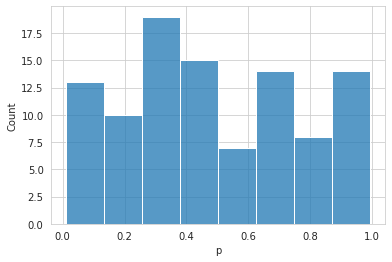

In [22]:
#for i in [0,0.1,0.3,0.5,1]:
#    for j in [0, 0.3, 0.6, 0.9]:
sns.histplot( df[(df.yc_in_yhat==0.3) &
                 (df.c_to_y_ratio_in_yhat==0) &
                 (df.n == 1000) &
                 (df.cov_y_c==0.6)
              ].p)

In [23]:
np.unique(df.c_to_y_ratio_in_yhat)

array([0. , 0.1, 0.3, 0.5, 1. ])